In [46]:
#Sagemaker stuff
from sagemaker import get_execution_role

role = get_execution_role()
role

'arn:aws:iam::634562090125:role/service-role/AmazonSageMaker-ExecutionRole-20200928T135555'

In [47]:
#Sagemaker stuff
bucket = 'sagemaker-imagecaption'

In [3]:
# If spacy is not installed for captions
!pip install spacy

     |████████████████████████████████| 9.9 MB 14.6 MB/s eta 0:00:01     |███████████████████▍            | 6.0 MB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 185 kB 91.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 62.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 84.1 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 84.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [53]:
# Imports
import pandas as pd
import spacy
import string
import pickle
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add

from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

## Text Preprocessing

In [73]:
# NOT REQUIRED IF YOU HAVE THE SAVED DICT

In [10]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [11]:
# !unzip Flickr8k_text.zip

In [12]:
filename = 'Flickr8k.token.txt'

In [13]:
file = open(filename, 'r')
# read all text
text = file.readlines()
# close the file
file.close()

text[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n']

In [14]:
image_id = []
caption = []
for each_pair in text:
    splits= each_pair.split('#')
    image_id.append(splits[0])
    caption.append('#'.join(splits[1:]))
    # Just to check how to captions formed back for those more than three splits
    if len(splits) != 2:
        print('#'.join(splits[1:]))

0	A football player is in a red and white uniform Sooners # 28 .

1	A black greyhound , with a green and white jersey ( # 7 ) is running on a track .

4	The # 2 greyhound dog is running around a track .

3	a university of Miami football player # 25 .

4	Closeup of football player # 25 .

4	White dog with yellow and black # 8 jacket in front of pack of dogs in race

2	Florida men 's basketball player # 33 shooting basketball .

3	Grey dog with muzzle and with the # 8 yellow striped identification is running .

3	Soccer player # 13 takes a shot on goal with four defenders and a goalie .

4	The racing dog has a muzzle and is wearing striped jersey # 8 .

2	Race dog # 2 is ahead of a few other dogs .

3	Greyhound dogs race on the track , with # 8 leading the way .



In [15]:
df = pd.DataFrame()
df['image_id'] = image_id
df['captions'] = caption

In [16]:
df.head()

,image_id,captions
0,1000268201_693b08cb0e.jpg,0\tA child in a pink dress is climbing up a se...
1,1000268201_693b08cb0e.jpg,1\tA girl going into a wooden building .\n
2,1000268201_693b08cb0e.jpg,2\tA little girl climbing into a wooden playho...
3,1000268201_693b08cb0e.jpg,3\tA little girl climbing the stairs to her pl...
4,1000268201_693b08cb0e.jpg,4\tA little girl in a pink dress going into a ...


In [17]:
!python -m spacy download en_core_web_sm

In [18]:
import en_core_web_sm

In [19]:
nlp = en_core_web_sm.load()

In [20]:
import string

def clean_captions(x):
    clean_caption_text = []
    for token in nlp(x.strip().lower()):
        if token.text in string.punctuation or len(token.text) <= 1 or not token.text.isalpha():
            continue
        # print(token)
        clean_caption_text.append(token.text)
    return clean_caption_text

In [21]:
%%time
df['tokenized_captions'] = df['captions'].apply(lambda x: clean_captions(x))

CPU times: user 5min 48s, sys: 232 ms, total: 5min 48s
Wall time: 5min 48s


In [22]:
df.head()

,image_id,captions,tokenized_captions
0,1000268201_693b08cb0e.jpg,0\tA child in a pink dress is climbing up a se...,"[child, in, pink, dress, is, climbing, up, set..."
1,1000268201_693b08cb0e.jpg,1\tA girl going into a wooden building .\n,"[girl, going, into, wooden, building]"
2,1000268201_693b08cb0e.jpg,2\tA little girl climbing into a wooden playho...,"[little, girl, climbing, into, wooden, playhouse]"
3,1000268201_693b08cb0e.jpg,3\tA little girl climbing the stairs to her pl...,"[little, girl, climbing, the, stairs, to, her,..."
4,1000268201_693b08cb0e.jpg,4\tA little girl in a pink dress going into a ...,"[little, girl, in, pink, dress, going, into, w..."


In [23]:
df['lstm_input'] = df['tokenized_captions'].apply(lambda x: ['startseq'] + x +['endseq'])
df['image_id_cleaned'] = df.image_id.str.split('.',  expand=True)[0]
captions_dict = {}
for unique_ids in list(df['image_id_cleaned'].unique()):
    # dict_image_captions[unique_ids] = 
    captions_list = list(df.loc[df['image_id_cleaned'] == unique_ids, 'lstm_input'])
    captions_joined_list = []
    for each_caption in captions_list:
        captions_joined_list.append(' '.join(each_caption))
    captions_dict[unique_ids] = captions_joined_list

## RUN THIS BLOCK WITH CORRECT PATH TO CAPTIONS DICT PICKLE

In [5]:
import os
full_path = os.getcwd()
captions_dict = pickle.load(open('image_captions_augmented_.pkl', 'rb'))

In [6]:
train_6k_captions = {k: captions_dict[k] for k in list(captions_dict)[:6000]}
test_1k_captions = {k: captions_dict[k] for k in list(captions_dict)[6000:7000]}

In [7]:
def to_lines(descriptions: dict) -> list:
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [8]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions:dict) -> list:
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [9]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [10]:
if train_6k_captions['2258277193_586949ec62']:
    del train_6k_captions['2258277193_586949ec62']
elif test_1k_captions['2258277193_586949ec62']:
    del test_1k_captions['2258277193_586949ec62']

In [11]:
tokenizer = create_tokenizer(train_6k_captions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_6k_captions)

Vocabulary Size: 7400


## Image Feature Extraction - Not Required if you have the weights

In [12]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [26]:
# !unzip Flickr8k_Dataset.zip

In [27]:
# !ls

In [28]:
import os

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
#     print('Hi1')
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
#     print('Hi2')
    print(model.summary())
    # extract features from each photo
    features = dict()
#     print('Hi1')
    for name in os.listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

In [ ]:
%%time
# extract features from all images
full_path = os.getcwd()
directory = 'Flicker8k_Dataset'
features_vgg16 = extract_features(full_path + '/' + directory)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Run This Block to Load the Extracted Features

In [12]:
import os
full_path = os.getcwd()
features_vgg16 = pickle.load(open('VGG16_extracted_image_features.pkl', 'rb'))

In [13]:
train_image_features = {}
test_image_features = {}
for key in captions_dict:
    if key in train_6k_captions:
        train_image_features[key] = features_vgg16[key]
    elif key in test_1k_captions:
        test_image_features[key] = features_vgg16[key]
        
len(train_image_features), len(test_image_features)

(5999, 1000)

#### The following code is taking loads of time to generate the inputs and outputs

In [21]:
# import numpy as np
# def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
#     X1, X2, y = list(), list(), list()
#     # walk through each image identifier
#     for key, desc_list in descriptions.items():
# #         junk = gc.collect()
#         # walk through each description for the image
#         for desc in desc_list:
#             # encode the sequence
#             seq = tokenizer.texts_to_sequences([desc])[0]
#             # split one sequence into multiple X,y pairs
#             for i in range(1, len(seq)):
#                 # split into input and output pair
#                 in_seq, out_seq = seq[:i], seq[i]
#                 # pad input sequence
#                 in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                 # encode output sequence
#                 out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#                 # store
#                 X1.append(photos[key][0])
#                 X2.append(in_seq)
#                 y.append(out_seq)
#     return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# import gc
# gc.collect()
# gc.collect()

In [23]:
# %%time
# X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_6k_captions, train_image_features, vocab_size)
# X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_1k_captions, test_image_features, vocab_size)

In [ ]:
# X1train.shape, X2train.shape, ytrain.shape

#### Therefore Use Prgressive loading 

In [18]:

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

In [19]:
# test the data generator
generator = data_generator(train_6k_captions, train_image_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 35)
(47, 7400)


In [20]:
#just in case
pickle.dump(inputs, open('inputs.pkl', 'wb'))
pickle.dump(outputs, open('outputs.pkl', 'wb'))

In [21]:
# test the data generator
generator = data_generator(test_1k_captions, test_image_features, tokenizer, max_length, vocab_size)
test_inputs, test_outputs = next(generator)
print(test_inputs[0].shape)
print(test_inputs[1].shape)
print(test_outputs.shape)

(49, 4096)
(49, 35)
(49, 7400)


In [22]:
#just in case
pickle.dump(test_inputs, open('test_inputs.pkl', 'wb'))
pickle.dump(test_inputs, open('test_outputs.pkl', 'wb'))

In [27]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    #Why?
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [26]:
# If you want to plot the model
!pip install pydot

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
# This one did not finish printing worked completely since all the 5 models are downloaded.

%%time
epochs = 5
steps = len(train_6k_captions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_6k_captions, train_image_features, tokenizer, max_length, vocab_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
5999/5999 [==============================] - 1434s 239ms/step - loss: 3.5162
Epoch 1/1
5999/5999 [==============================] - 1423s 237ms/step - loss: 3.4017
Epoch 1/1
5999/5999 [==============================] - 1444s 241ms/step - loss: 3.3367
Epoch 1/1
2195/5999 [=========>....................] - ETA: 15:13 - loss: 3.2715

In [30]:
# If you use history - Not used in the generator loading method
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [55]:
# Required for loading the five models

from keras.models import load_model

list_models = [load_model('model_'+ str(i) +'.h5') for i in range(5)]

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anac

In [59]:
list_models[0].summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 256)      1894400     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [63]:
list_models[0].evaluate_generator()

([1.0], [1.0])

In [64]:
# Copied from the blog the blog for testing - Ned to look what's in it. Clearly prediting and organizing 
# but need to take a deeper look

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # pQredict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

1000268201_693b08cb0e
startseq the sidewalk of the sidewalk endseq
1000268201_693b08cb0e
startseq the man is holding his hair and wearing pink shirt endseq
1000268201_693b08cb0e
startseq man is standing on the the side of the street endseq
1000268201_693b08cb0e
startseq man in blue shirt is standing on the sidewalk endseq
1000268201_693b08cb0e
startseq man in blue shirt is standing in front of the street endseq


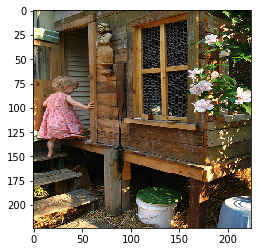

In [76]:
for each_model in list_models:
    for key, desc_list in train_6k_captions.items():
        # generate description
        yhat = generate_desc(each_model, tokenizer, train_image_features[key], max_length)
        print(key)
        test_img = load_img('Flicker8k_Dataset/'+ key + '.jpg', target_size = (224,224,3))
        plt.imshow(test_img)
        print(yhat)
        break

In [77]:
tokenizer

3560977956_e08d2cd531
startseq man in blue shirt is jumping into the air into the water endseq
3563668905_689ed479c5
startseq man in blue shirt is riding bike on the dirt endseq
3556598205_86c180769d
startseq man in blue shirt is riding bike on the dirt endseq
3708244207_0d3a2b2f92
startseq man in blue shirt is jumping into the air on the beach endseq
3583321426_f373c52161
startseq man in blue shirt is standing on the sidewalk with his hand endseq


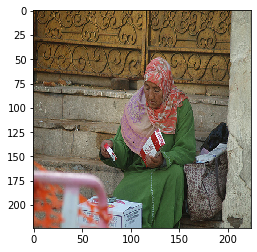

In [81]:
import random
for each_model in list_models:
    key = random.sample(test_1k_captions.keys(), k=1)[0]
    # generate description
    yhat = generate_desc(each_model, tokenizer, test_image_features[key], max_length)
    print(key)
    test_img = load_img('Flicker8k_Dataset/'+ key + '.jpg', target_size = (224,224,3))
    plt.imshow(test_img)
    print(yhat)
#     break

3606355203_1260f43ec0
startseq man in blue shirt is jumping into the air endseq
3628017876_4ac27e687b
startseq two children are playing soccer endseq
3690159129_93ba49ea18
startseq man in blue shirt is riding bike on the sidewalk endseq
3589368949_0866846949
startseq man in blue shirt is standing in front of building endseq
3677734351_63d60844cb
startseq man in blue shirt is standing in front of the street endseq


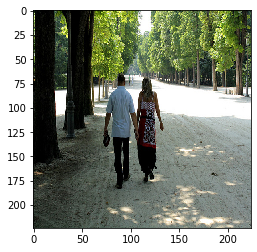

In [82]:
import random
for each_model in list_models:
    key = random.sample(test_1k_captions.keys(), k=1)[0]
    # generate description
    yhat = generate_desc(each_model, tokenizer, test_image_features[key], max_length)
    print(key)
    test_img = load_img('Flicker8k_Dataset/'+ key + '.jpg', target_size = (224,224,3))
    plt.imshow(test_img)
    print(yhat)
#     break

3535304540_0247e8cf8c
startseq man in blue shirt is riding his bike on the beach endseq
3537520829_aab733e16c
startseq man in blue shirt is riding bike on the street endseq
3595992258_6f192e6ae7
startseq dog is running through the snow endseq
3587449716_3bf1552c36
startseq man in black shirt is standing in front of building endseq
3537218226_478d2e4f26
startseq man in blue shirt is jumping over the top of the ramp endseq


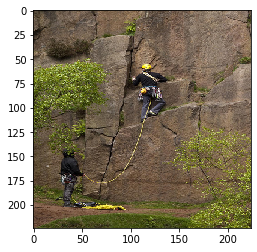

In [83]:
import random
for each_model in list_models:
    key = random.sample(test_1k_captions.keys(), k=1)[0]
    # generate description
    yhat = generate_desc(each_model, tokenizer, test_image_features[key], max_length)
    print(key)
    test_img = load_img('Flicker8k_Dataset/'+ key + '.jpg', target_size = (224,224,3))
    plt.imshow(test_img)
    print(yhat)
#     break

3538527033_df13112d51
startseq man in blue shirt is standing on the street endseq
3677329561_fa3e1fdcf9
startseq dog is running through the snow endseq
3611672054_45edd3e08f
startseq two people are playing in the water endseq
3652584682_5b5c43e445
startseq man in blue shirt is jumping into the air endseq
3608849440_e7d2bed29f
startseq man in blue shirt is playing tennis endseq


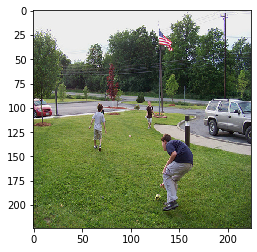

In [84]:
import random
for each_model in list_models:
    key = random.sample(test_1k_captions.keys(), k=1)[0]
    # generate description
    yhat = generate_desc(each_model, tokenizer, test_image_features[key], max_length)
    print(key)
    test_img = load_img('Flicker8k_Dataset/'+ key + '.jpg', target_size = (224,224,3))
    plt.imshow(test_img)
    print(yhat)
#     break

In [74]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()